In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

figsize=(14, 4)

random_state = 42   

from utils.data_visualizator import plot_confusion_matrix

from utils import DataAggregator

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Concatenate
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import MeanSquaredError, SparseCategoricalCrossentropy

from sklearn.preprocessing import StandardScaler

import pandas as pd

In [2]:
data_aggregator = DataAggregator()

In [3]:
df = data_aggregator.get_data(["E0"])
df = data_aggregator.format_date(df, "Date")
df = data_aggregator.encode_result(df,
                        mapping={"H": 1, "D": 0, "A": -1}, 
                        result_column="FTR")
df = data_aggregator.create_form_data(df, form_window=5)
df = data_aggregator.create_gd_feature(df)
df.drop(columns=["Div", "FTHG", "FTAG", "HTHG", "HTAG", "HTR", "Referee", "HS", "AS", "HST", "AST", "HF", "AF", "HC","AC","HY","AY","HR","AR"], inplace=True)
df = data_aggregator.one_hot_encode_teams(df, "HomeTeam", "AwayTeam")

In [4]:
target = "FTR"
GD_target = "GD"

df_train = df[df["Date"] < "2023-07-01"]
df_test = df[df["Date"] >= "2023-07-01"]
df_test = df_test[df_test["Date"] < "2024-07-01"]

X_train = df_train.drop(columns=[target, "Date", "FTR", GD_target])
y_train = df_train[target]
y_train_gd = df_train[GD_target]
X_test = df_test.drop(columns=[target, "Date", "FTR", GD_target])
y_test = df_test[target]
y_test_gd = df_test[GD_target]

In [5]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
input_dim = X_train.shape[1]

## Classifier
First of all, we start by creating a neural network that will act as a classifier. We will use it to classify the matches into categorical "Win", "Draw" and "Loss".

In [6]:
def create_classifier(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
y_train_cls = to_categorical(y_train.map({-1: 0, 0: 1, 1: 2}))
y_test_cls = to_categorical(y_test.map({-1: 0, 0: 1, 1: 2}))

In [ ]:
classifier = create_classifier(input_dim)
print(classifier.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,835 (34.51 KB)

 Trainable params: 8,835 (34.51 KB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
history = classifier.fit(X_train, y_train_cls, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4500 - loss: 1.1534 - val_accuracy: 0.5514 - val_loss: 0.9674
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.5333 - loss: 0.9753 - val_accuracy: 0.5633 - val_loss: 0.9407
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.5678 - loss: 0.9250 - val_accuracy: 0.5727 - val_loss: 0.9173
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.5861 - loss: 0.8943 - val_accuracy: 0.5752 - val_loss: 0.9118
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.5904 - loss: 0.8905 - val_accuracy: 0.5821 - val_loss: 0.9059
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.6059 - loss: 0.8674 - val_accuracy: 0.5852 - val_loss: 0.9002
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.5999 - loss: 0.8634 - val_accuracy: 0.5815 - val_loss: 0.9003
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.6214 - loss: 0.8400 - va

In [10]:
y_pred_cls = classifier.predict(X_test)
mapped_predictions_cls = y_pred_cls.argmax(axis=1) - 1

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [11]:
cls_df = pd.concat([df_test[[target, "B365H", "B365D", "B365A"]].reset_index(drop=True), pd.Series(mapped_predictions_cls, name="PredictedOutcome")], axis=1)

cls_accuracy, cls_won = data_aggregator.calculate_accuracy(cls_df, target, "PredictedOutcome")

print(f"""The accuracy of the model is {cls_accuracy:.2%}
The accuracy of the model is {cls_accuracy*len(cls_df):.0f} out of {len(cls_df)} games.
""")
print(f"With this model, the expected return on value would be {cls_won:.2f}€")

The accuracy of the model is 61.84%
The accuracy of the model is 235 out of 380 games.

With this model, the expected return on value would be 8280.60€


In [12]:
print(classification_report(y_test, mapped_predictions_cls))

              precision    recall  f1-score   support

          -1       0.67      0.60      0.64       123
           0       0.43      0.20      0.27        82
           1       0.62      0.83      0.71       175

    accuracy                           0.62       380
   macro avg       0.58      0.54      0.54       380
weighted avg       0.60      0.62      0.59       380



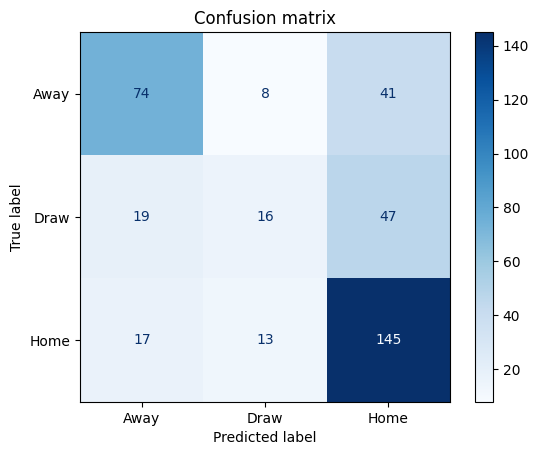

In [13]:
cm = confusion_matrix(y_test, mapped_predictions_cls)
plot_confusion_matrix(cm, ["Away", "Draw", "Home"])

## Regressor
Next up we will define a neural network as a regressor, and will use it to predict the goal difference of a match.

In [14]:
def create_regressor(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [15]:
regressor = create_regressor(input_dim)
print(regressor.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769 (34.25 KB)

 Trainable params: 8,769 (34.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [16]:
history = regressor.fit(X_train, y_train_gd, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.0966 - mae: 1.3715 - val_loss: 2.7828 - val_mae: 1.2956
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 2.3359 - mae: 1.1946 - val_loss: 2.5575 - val_mae: 1.2443
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 2.1615 - mae: 1.1548 - val_loss: 2.4666 - val_mae: 1.2223
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 1.9921 - mae: 1.1090 - val_loss: 2.3768 - val_mae: 1.1973
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 1.9185 - mae: 1.0894 - val_loss: 2.3890 - val_mae: 1.2056
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 1.8819 - mae: 1.0853 - val_loss: 2.3016 - val_mae: 1.1861
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 1.7946 - mae: 1.0534 - val_loss: 2.2879 - val_mae: 1.1866
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 1.8478 - mae: 1.0699 - val_loss: 2.2659 - val_mae: 1.1844
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s

In [28]:
def map_result(predicitions):
    return [1 if p >= 1 else -1 if p <= -1 else 0 for p in map(round, predicitions)]

y_pred = regressor.predict(X_test).flatten()

mapped_predictions = map_result(y_pred)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step


In [29]:
regr_df = pd.concat([df_test[[target, "B365H", "B365D", "B365A"]].reset_index(drop=True), pd.Series(mapped_predictions, name="PredictedOutcome")], axis=1)

regr_accuracy, regr_won = data_aggregator.calculate_accuracy(regr_df, target, "PredictedOutcome")

print(f"""The accuracy of the model is {regr_accuracy:.2%}
The accuracy of the model is {regr_accuracy*len(regr_df):.0f} out of {len(regr_df)} games.
""")
print(f"With this model, the expected return on value would be {regr_won:.2f}€")

The accuracy of the model is 53.42%
The accuracy of the model is 203 out of 380 games.

With this model, the expected return on value would be 6599.70€


In [30]:
print(classification_report(y_test, mapped_predictions))

              precision    recall  f1-score   support

          -1       0.68      0.53      0.60       123
           0       0.26      0.49      0.34        82
           1       0.76      0.56      0.64       175

    accuracy                           0.53       380
   macro avg       0.57      0.53      0.53       380
weighted avg       0.63      0.53      0.56       380



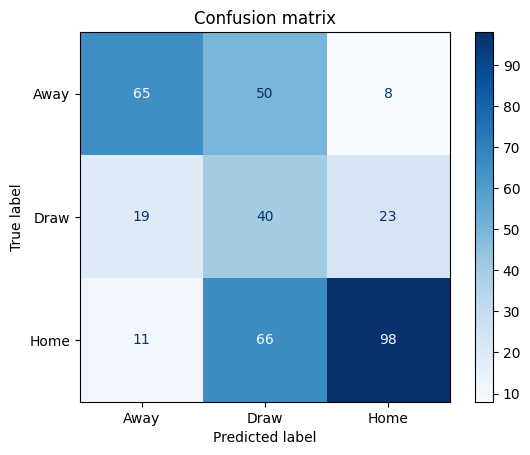

In [31]:
cm = confusion_matrix(y_test, mapped_predictions)
plot_confusion_matrix(cm, ["Away", "Draw", "Home"])

## Hybrid approach
Finally, we will implement a hybrid variant, where we will take the output of the regressor, i.e., the predicted goal difference, and then use it as a input to a classifier NN in order to predict the results using another NN.

In [21]:
def create_hybrid_model(input_dim):
    inputs = Input(shape=(input_dim,), name="main_input")
    
    regressor = Dense(64, activation="relu", name="regressor_hidden_1")(inputs)
    regressor = Dropout(0.2)(regressor)
    regressor = Dense(32, activation="relu", name="regressor_hidden_2")(regressor)
    gd_output = Dense(1, activation="linear", name="goal_difference_output")(regressor)  # Regression output

    concatenated = Concatenate(name="concat_layer")([inputs, gd_output])
    
    classifier = Dense(64, activation="relu", name="classifier_hidden_1")(concatenated)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(32, activation="relu", name="classifier_hidden_2")(classifier)
    outcome_output = Dense(3, activation="softmax", name="match_outcome_output")(classifier)  # Classification output

    model = Model(inputs=inputs, outputs=[gd_output, outcome_output])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={
            "goal_difference_output": MeanSquaredError(),
            "match_outcome_output": SparseCategoricalCrossentropy()
        },
        metrics={
            "goal_difference_output": "mae",
            "match_outcome_output": "accuracy"
        }
    )
    return model

In [22]:
hybrid_model = create_hybrid_model(input_dim)
print(hybrid_model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 103)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regressor_hidden_1  │ (None, 64)        │      6,656 │ main_input[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ regressor_hidden… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regressor_hidden_2  │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ goal_difference_ou… │ (None, 1)         │         33 │ regressor_hidden… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, 104)       │          0 │ main_input[0][0], │
│ (Concatenate)       │                   │            │ goal_difference_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_hidden_1 │ (None, 64)        │      6,720 │ concat_layer[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ classifier_hidde… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_hidden_2 │ (None, 32)        │      2,080 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ match_outcome_outp… │ (None, 3)         │         99 │ classifier_hidde… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,668 (69.02 KB)

 Trainable params: 17,668 (69.02 KB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
history = hybrid_model.fit(
    X_train,
    {"goal_difference_output": y_train_gd, "match_outcome_output": y_train.map({-1: 0, 0: 1, 1: 2})},
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - goal_difference_output_loss: 3.0264 - goal_difference_output_mae: 1.3477 - loss: 4.1424 - match_outcome_output_accuracy: 0.4332 - match_outcome_output_loss: 1.1160 - val_goal_difference_output_loss: 2.7101 - val_goal_difference_output_mae: 1.2808 - val_loss: 3.6912 - val_match_outcome_output_accuracy: 0.5363 - val_match_outcome_output_loss: 0.9806
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - goal_difference_output_loss: 2.2193 - goal_difference_output_mae: 1.1651 - loss: 3.1529 - match_outcome_output_accuracy: 0.5629 - match_outcome_output_loss: 0.9336 - val_goal_difference_output_loss: 2.5217 - val_goal_difference_output_mae: 1.2471 - val_loss: 3.4737 - val_match_outcome_output_accuracy: 0.5589 - val_match_outcome_output_loss: 0.9519
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - goal_difference_output_loss: 2.0085 - goal_difference_output_mae: 1.1110 - loss: 2.8974 - match_outcome_output_accuracy: 0.5875 - match_ou

In [32]:
y_pred_gd, y_pred_cls = hybrid_model.predict(X_test)

mapped_predictions_gd = map_result(y_pred_gd.flatten())
mapped_predictions_cls = y_pred_cls.argmax(axis=1) - 1

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step


In [33]:
regr_accuracy, regr_won = data_aggregator.calculate_accuracy(regr_df, target, "PredictedOutcome")
print("Regression predictions:")
print(f"""The accuracy of the model is {regr_accuracy:.2%}
The accuracy of the model is {regr_accuracy*len(regr_df):.0f} out of {len(regr_df)} games.
""")
print(f"With this model, the expected return on value would be {regr_won:.2f}€")

Regression predictions:
The accuracy of the model is 53.42%
The accuracy of the model is 203 out of 380 games.

With this model, the expected return on value would be 6599.70€


In [34]:
cls_accuracy, cls_won = data_aggregator.calculate_accuracy(cls_df, target, "PredictedOutcome")
print("Classification predictions:")
print(f"""The accuracy of the model is {cls_accuracy:.2%}
The accuracy of the model is {cls_accuracy*len(cls_df):.0f} out of {len(cls_df)} games.
""")
print(f"With this model, the expected return on value would be {cls_won:.2f}€")

Classification predictions:
The accuracy of the model is 61.84%
The accuracy of the model is 235 out of 380 games.

With this model, the expected return on value would be 8280.60€


Well, as we can see from the output above, the model actually just ignores the predicted goal difference feature. Meaning that the dataset itself is good enough to predict the matches with approx 62% accuracy. In order to achieve better result, we should append more features, and maybe include more form data such as 3 game form, 5 game form, 10 game form, the form against a similar opponent previous...

In [35]:
data_aggregator.save_metrics("nn_cls", cls_accuracy, cls_won)
data_aggregator.save_metrics("nn_regr", regr_accuracy, regr_won)